# Different Model Types

* ## Linear Regression Model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize, LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import re

In [4]:
def safe_to_numeric(series):
    return pd.to_numeric(series, errors='coerce')

def safe_to_datetime(series):
    return pd.to_datetime(series, errors='coerce')

In [5]:
df_median_wages = pd.read_csv("cleaned_data/median_wages_clean.csv")
df_mehoin = pd.read_csv("cleaned_data/mehoin_clean.csv")
df_cclac = pd.read_csv("cleaned_data/cclac_clean.csv")
df_busloans = pd.read_csv("cleaned_data/busloans_clean.csv")
df_complaints = pd.read_csv("cleaned_data/complaints_clean.csv")
df_sod = pd.read_csv("cleaned_data/sod_clean.csv", low_memory=False)

In [6]:
if 'year' in df_median_wages.columns:
    df_median_wages['year'] = safe_to_numeric(df_median_wages['year'])
    numeric_cols_mw = df_median_wages.select_dtypes(include=np.number).columns
    df_median_wages = df_median_wages[numeric_cols_mw]

else:

    df_median_wages = pd.DataFrame({'year': []})

In [7]:
if 'date' in df_mehoin.columns:
    df_mehoin['date'] = safe_to_datetime(df_mehoin['date'])
    df_mehoin['year'] = df_mehoin['date'].dt.year
    df_mehoin = df_mehoin.rename(columns={'median_household_income': 'MEHOIN'})
    df_mehoin['MEHOIN'] = safe_to_numeric(df_mehoin['MEHOIN'])
    df_mehoin = df_mehoin.groupby('year')['MEHOIN'].mean().reset_index()
else:
    df_mehoin = pd.DataFrame({'year': [], 'MEHOIN': []})

In [8]:
if 'date' in df_cclac.columns:
    df_cclac['date'] = safe_to_datetime(df_cclac['date'])
    df_cclac['year'] = df_cclac['date'].dt.year
    df_cclac = df_cclac.rename(columns={'consumer_credit_value': 'CCLAC'})
    df_cclac['CCLAC'] = safe_to_numeric(df_cclac['CCLAC'])
    df_cclac = df_cclac.groupby('year')['CCLAC'].mean().reset_index()
else:
    df_cclac = pd.DataFrame({'year': [], 'CCLAC': []})

In [9]:
if 'date' in df_busloans.columns:
    df_busloans['date'] = safe_to_datetime(df_busloans['date'])
    df_busloans['year'] = df_busloans['date'].dt.year
    df_busloans = df_busloans.rename(columns={'business_loan_value': 'BUSLOANS'})
    df_busloans['BUSLOANS'] = safe_to_numeric(df_busloans['BUSLOANS'])
    df_busloans = df_busloans.groupby('year')['BUSLOANS'].mean().reset_index()
else:
    raise ValueError("Date not in bus_loans")

In [10]:
if 'date_received' in df_complaints.columns:
    df_complaints['date_received'] = safe_to_datetime(df_complaints['date_received'])
    df_complaints['year'] = df_complaints['date_received'].dt.year
    df_complaints_agg = df_complaints.groupby('year').size().reset_index(name='complaint_count')
else:
    df_complaints_agg = pd.DataFrame({'year': [], 'complaint_count': []})

In [11]:
if 'year' in df_sod.columns and 'total_deposits' in df_sod.columns:
    df_sod['year'] = safe_to_numeric(df_sod['year'])
    df_sod['total_deposits'] = safe_to_numeric(df_sod['total_deposits'])
    df_sod_agg = df_sod.groupby('year')['total_deposits'].sum().reset_index()
else:
    df_sod_agg = pd.DataFrame({'year': [], 'total_deposits': []})

In [12]:
merged_df = df_busloans
print(f"Shape {merged_df.shape})")
dfs_to_merge = {
    "median_wages": df_median_wages, "mehoin": df_mehoin, "cclac": df_cclac,
    "complaints_agg": df_complaints_agg, "sod_agg": df_sod_agg
}

Shape (79, 2))


In [13]:
for name, df in dfs_to_merge.items():
    if 'year' in df.columns and df['year'].nunique() > 0:
        if not pd.api.types.is_numeric_dtype(merged_df['year']):
            merged_df['year'] = safe_to_numeric(merged_df['year'])
            
        if not pd.api.types.is_numeric_dtype(df['year']):
            df['year'] = safe_to_numeric(df['year'])

        merged_df.dropna(subset=['year'], inplace=True)
        df.dropna(subset=['year'], inplace=True)

        merged_df = pd.merge(merged_df, df, on='year', how='left')
        print(f"Merged {name}. new shape: {merged_df.shape}")
    else:
        print(f"It friggin didnt work {name}: you suck")

Merged median_wages. new shape: (79, 26)
Merged mehoin. new shape: (79, 27)
Merged cclac. new shape: (79, 28)
Merged complaints_agg. new shape: (79, 29)
Merged sod_agg. new shape: (79, 30)


In [14]:
merged_df.dropna(subset=['BUSLOANS'], inplace=True)
merged_df.dropna(subset=['year'], inplace=True)
feature_cols = [col for col in merged_df.columns if col not in ['year', 'BUSLOANS']]
merged_df.dropna(subset=feature_cols, how='all', inplace=True)
print(f"Shape after change: {merged_df.shape}")

Shape after change: (53, 30)


In [15]:
if merged_df.shape[0] < 2:
    raise ValueError(f"cant proceed ({merged_df.shape[0]} rows)")

In [16]:
X = merged_df.drop(columns=['year', 'BUSLOANS'])
y = merged_df['BUSLOANS']
X = X.apply(pd.to_numeric, errors='coerce')
test_size_ratio = 0.2
n_samples = len(merged_df)
n_test_samples = max(1, int(test_size_ratio * n_samples))

In [17]:
if n_samples - n_test_samples < 1:
    print("Too small to train.")
    X_train, X_test, y_train, y_test = X, X.iloc[0:0], y, y.iloc[0:0]
else:
    test_size_param = n_test_samples
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_param, random_state=42)

In [18]:
print(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

Train set shape: X=(43, 28), y=(43,)
Test set shape: X=(10, 28), y=(10,)


In [19]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()),                  
    ('regression', LinearRegression())             
])
pipeline.fit(X_train, y_train)
y_pred_train = pipeline.predict(X_train)

In [20]:
print(f"R^2: {r2_score(y_train, y_pred_train):.3f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.3f}")
print(f"MSE: {mean_squared_error(y_train, y_pred_train):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.3f}")

R^2: 0.990
MAE: 56.772
MSE: 5444.906
RMSE: 73.790


In [21]:
if X_test.shape[0] > 0: 
    y_pred_test = pipeline.predict(X_test)
    print(f"R^2: {r2_score(y_test, y_pred_test):.3f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.3f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred_test):.3f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.3f}")
else:
    print("No Samples.")

R^2: 0.866
MAE: 289.691
MSE: 119228.992
RMSE: 345.296


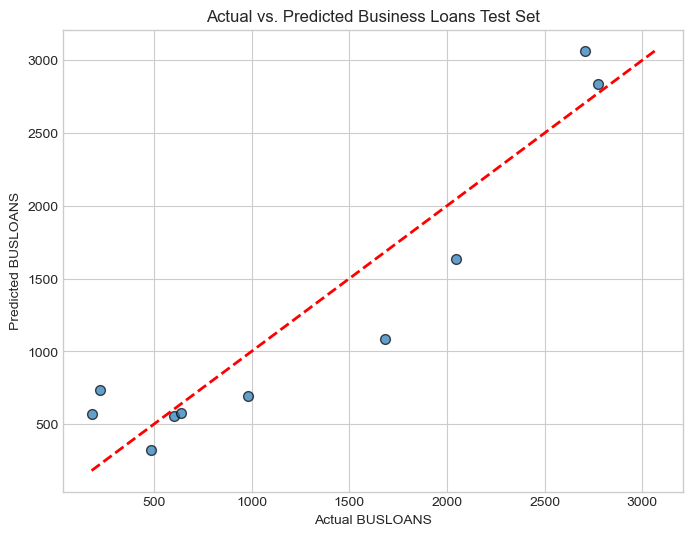

In [22]:
plt.style.use('seaborn-v0_8-whitegrid') 

if X_test.shape[0] > 0:
    plot_y_actual = y_test
    plot_y_pred = y_pred_test
    plot_title = "Actual vs. Predicted Business Loans Test Set"
else:
    plot_y_actual = y_train
    plot_y_pred = y_pred_train
    plot_title = "Actual vs. Predicted Business Loans Train Set"

plt.figure(figsize=(8, 6))
plt.scatter(plot_y_actual, plot_y_pred, alpha=0.7, edgecolors='k', s=50)
if plot_y_actual.size > 0 and plot_y_pred.size > 0: 
    min_val = min(plot_y_actual.min(), plot_y_pred.min())
    max_val = max(plot_y_actual.max(), plot_y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='red') 

plt.xlabel("Actual BUSLOANS")
plt.ylabel("Predicted BUSLOANS")
plt.title(plot_title)
plt.grid(True)
plt.show()

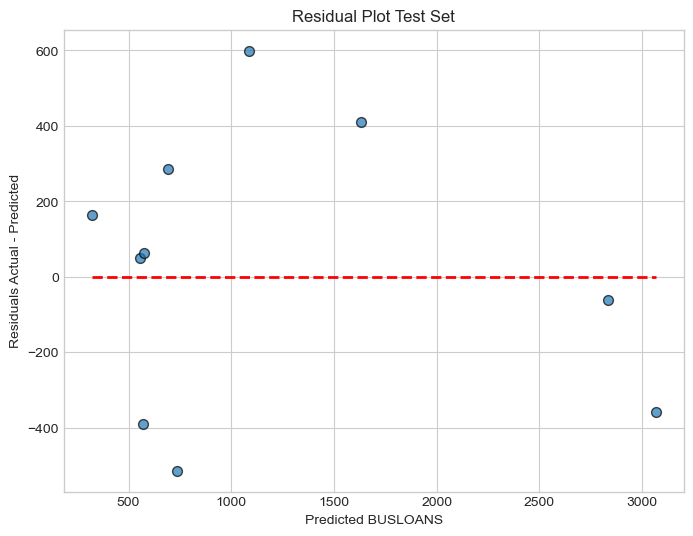

In [23]:
if X_test.shape[0] > 0:
    residuals = y_test - y_pred_test
    res_plot_y_pred = y_pred_test
    res_plot_title = "Residual Plot Test Set"
else:
    residuals = y_train - y_pred_train
    res_plot_y_pred = y_pred_train
    res_plot_title = "Residual Plot Train Set"

plt.figure(figsize=(8, 6))
plt.scatter(res_plot_y_pred, residuals, alpha=0.7, edgecolors='k', s=50)
if res_plot_y_pred.size > 0: 
    plt.hlines(0, res_plot_y_pred.min(), res_plot_y_pred.max(), linestyles='--', lw=2, color='red') 

plt.xlabel("Predicted BUSLOANS")
plt.ylabel("Residuals Actual - Predicted")
plt.title(res_plot_title)
plt.grid(True)
plt.show()

C:\Users\ncpr0\AppData\Local\Temp\ipykernel_14308\697763696.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


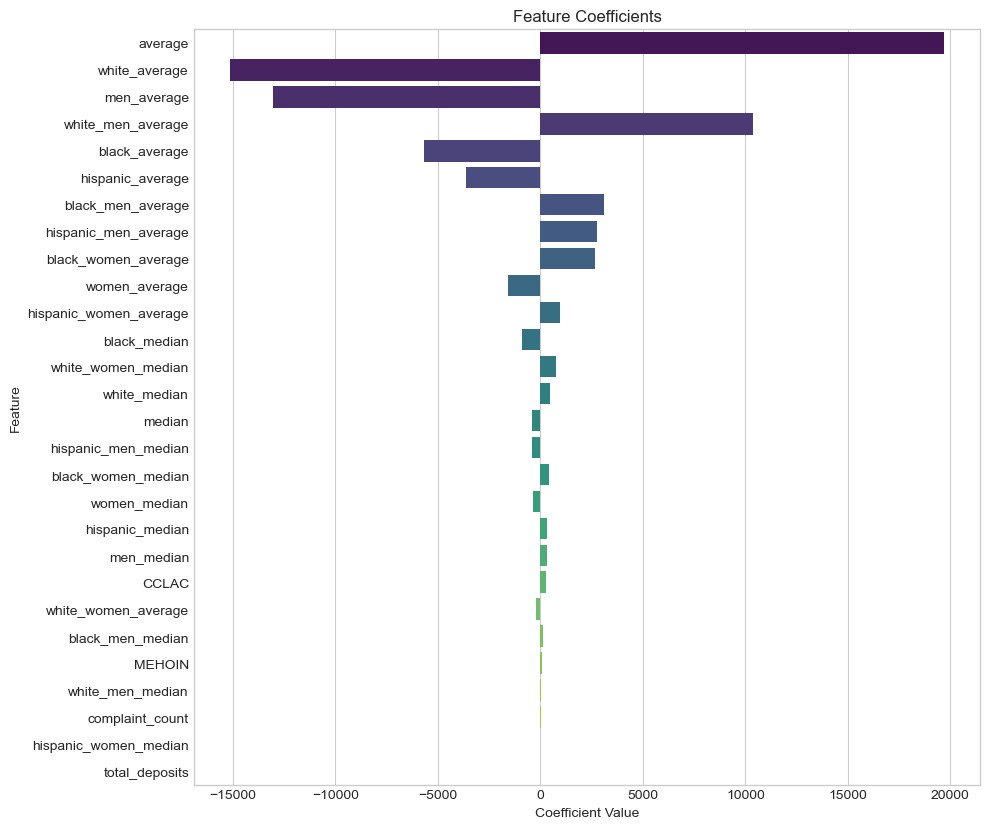

                   Feature   Coefficient
1                  average  19703.475142
7            white_average -15151.727451
3              men_average -13014.993403
13       white_men_average  10358.569728
9            black_average  -5672.002534
11        hispanic_average  -3609.636291
15       black_men_average   3117.788831
17    hispanic_men_average   2744.883985
21     black_women_average   2671.461729
5            women_average  -1555.557650
23  hispanic_women_average    980.692813
8             black_median   -874.206138
18      white_women_median    789.386624
6             white_median    454.781808
0                   median   -426.694606
16     hispanic_men_median   -408.980318
20      black_women_median    407.242274
4             women_median   -352.119251
10         hispanic_median    324.835217
2               men_median    304.610267
25                   CCLAC    291.989043
19     white_women_average   -206.951150
14        black_men_median    114.135941
24              

In [24]:
if hasattr(pipeline.named_steps['regression'], 'coef_'):
    feature_names = X.columns.tolist()

    if len(feature_names) == len(pipeline.named_steps['regression'].coef_):
        coefficients = pipeline.named_steps['regression'].coef_
        coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
        coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
        coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')

        plt.figure(figsize=(10, max(6, len(feature_names) * 0.3))) 
        sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
        plt.title('Feature Coefficients')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

        with pd.option_context('display.max_rows', 100):
            print(coef_df)
    else:
        print("Possible align prob.")
else:
    print("Coefficients.")

In [25]:
# def safe_to_numeric(series): return pd.to_numeric(series, errors='coerce')
# def safe_to_datetime(series): return pd.to_datetime(series, errors='coerce')

In [26]:
print("Styles:", plt.style.available)

Styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [27]:
plotting_style = 'seaborn-v0_8-darkgrid'
if plotting_style not in plt.style.available:
    print(f"Good'{plotting_style}'")
    plotting_style = 'ggplot'
    if plotting_style not in plt.style.available:
        print(f"None found for that")
        plotting_style = 'default'

In [28]:
num_sod_years = 0 # Initialize
if 'year' in df_sod.columns:
    sod_year_counts = df_sod['year'].value_counts()
    print(f"Value counts for 'year' in sod_clean.xls:\n{sod_year_counts}")
    num_sod_years = len(sod_year_counts)
    print(f"Number of unique years found in SOD data: {num_sod_years}")
else:
    print("\nColumn 'year' not found in SOD data.")

Value counts for 'year' in sod_clean.xls:
year
2024    76742
Name: count, dtype: int64
Number of unique years found in SOD data: 1


In [29]:
if 'year' in df_median_wages.columns:
    df_median_wages['year'] = safe_to_numeric(df_median_wages['year'])
    numeric_cols_mw = df_median_wages.select_dtypes(include=np.number).columns
    df_median_wages = df_median_wages[numeric_cols_mw]
else: df_median_wages = pd.DataFrame({'year': []})

In [30]:
if 'date' in df_mehoin.columns:
    df_mehoin['date'] = safe_to_datetime(df_mehoin['date']); df_mehoin['year'] = df_mehoin['date'].dt.year
    df_mehoin = df_mehoin.rename(columns={'median_household_income': 'MEHOIN'})
    df_mehoin['MEHOIN'] = safe_to_numeric(df_mehoin['MEHOIN'])
    df_mehoin = df_mehoin.groupby('year')['MEHOIN'].mean().reset_index()
else: df_mehoin = pd.DataFrame({'year': [], 'MEHOIN': []})

In [31]:
if 'date' in df_cclac.columns:
    df_cclac['date'] = safe_to_datetime(df_cclac['date']); df_cclac['year'] = df_cclac['date'].dt.year
    df_cclac = df_cclac.rename(columns={'consumer_credit_value': 'CCLAC'})
    df_cclac['CCLAC'] = safe_to_numeric(df_cclac['CCLAC'])
    df_cclac = df_cclac.groupby('year')['CCLAC'].mean().reset_index()
else: df_cclac = pd.DataFrame({'year': [], 'CCLAC': []})

In [32]:
if 'date_received' in df_complaints.columns:
    df_complaints['date_received'] = safe_to_datetime(df_complaints['date_received']); df_complaints['year'] = df_complaints['date_received'].dt.year
    df_complaints_agg = df_complaints.groupby('year').size().reset_index(name='complaint_count')
else: df_complaints_agg = pd.DataFrame({'year': [], 'complaint_count': []})

In [33]:
if num_sod_years > 1 and 'year' in df_sod.columns and 'total_deposits' in df_sod.columns:
     df_sod['year'] = safe_to_numeric(df_sod['year']); df_sod['total_deposits'] = safe_to_numeric(df_sod['total_deposits'])
     df_sod_agg = df_sod.groupby('year')['total_deposits'].sum().reset_index()
     print("Processed sod, success.")
elif num_sod_years == 1 and 'year' in df_sod.columns and 'total_deposits' in df_sod.columns:
     print("Processed sod only one year found, gonna merge but dont use time series")
     df_sod['year'] = safe_to_numeric(df_sod['year'])
     df_sod['total_deposits'] = safe_to_numeric(df_sod['total_deposits'])
     df_sod_agg = df_sod.groupby('year')['total_deposits'].sum().reset_index()
else:
     df_sod_agg = pd.DataFrame({'year': [], 'total_deposits': []})

Processed sod only one year found, gonna merge but dont use time series


In [34]:
if not df_median_wages.empty and 'year' in df_median_wages.columns:
    merged_df = df_median_wages
    print(f"Starting merge with median_wages (Shape: {merged_df.shape})")
elif not df_mehoin.empty and 'year' in df_mehoin.columns:
     merged_df = df_mehoin
     print(f"Starting merge with mehoin (Shape: {merged_df.shape})")
else: raise ValueError("Merge error prob because of year")

Starting merge with median_wages (Shape: (50, 25))


In [35]:
dfs_to_merge = {"mehoin": df_mehoin, "cclac": df_cclac, "complaints_agg": df_complaints_agg, "sod_agg": df_sod_agg}
if merged_df is df_mehoin and not df_median_wages.empty and 'year' in df_median_wages.columns:
    dfs_to_merge["median_wages"] = df_median_wages

In [36]:
for name, df in dfs_to_merge.items():
    if df is merged_df: continue
    if 'year' in df.columns and df['year'].nunique() > 0:
         if not pd.api.types.is_numeric_dtype(merged_df['year']): merged_df['year'] = safe_to_numeric(merged_df['year'])
         if not pd.api.types.is_numeric_dtype(df['year']): df['year'] = safe_to_numeric(df['year'])
         merged_df.dropna(subset=['year'], inplace=True); df.dropna(subset=['year'], inplace=True)
         try:
             merged_df['year'] = merged_df['year'].astype(int)
             df['year'] = df['year'].astype(int)
         except (ValueError, TypeError): pass
         merged_df = pd.merge(merged_df, df, on='year', how='left')

In [37]:
print(f"Shape before final cleaning: {merged_df.shape}")

Shape before final cleaning: (50, 27)


In [38]:
feature_cols = [col for col in merged_df.columns if col != 'year']
merged_df.dropna(subset=feature_cols, how='all', inplace=True)
merged_df.dropna(subset=['year'], inplace=True)

In [39]:
if pd.api.types.is_float_dtype(merged_df['year']):
     merged_df['year'] = merged_df['year'].astype(pd.Int64Dtype())
print(f"Final merged shape after cleaning: {merged_df.shape}")

Final merged shape after cleaning: (50, 27)


In [40]:
key_cols_check = ['year', 'median', 'MEHOIN', 'CCLAC', 'complaint_count', 'total_deposits']
key_cols_present = [col for col in key_cols_check if col in merged_df.columns]
if key_cols_present:
    print(merged_df[key_cols_present].isnull().sum())
else: print("\nCould not check missing values for key columns.")

year                0
median              0
complaint_count    38
total_deposits     50
dtype: int64


In [41]:
if merged_df.shape[0] < 2: raise ValueError("Not enough data error")

In [42]:
plt.style.use(plotting_style)

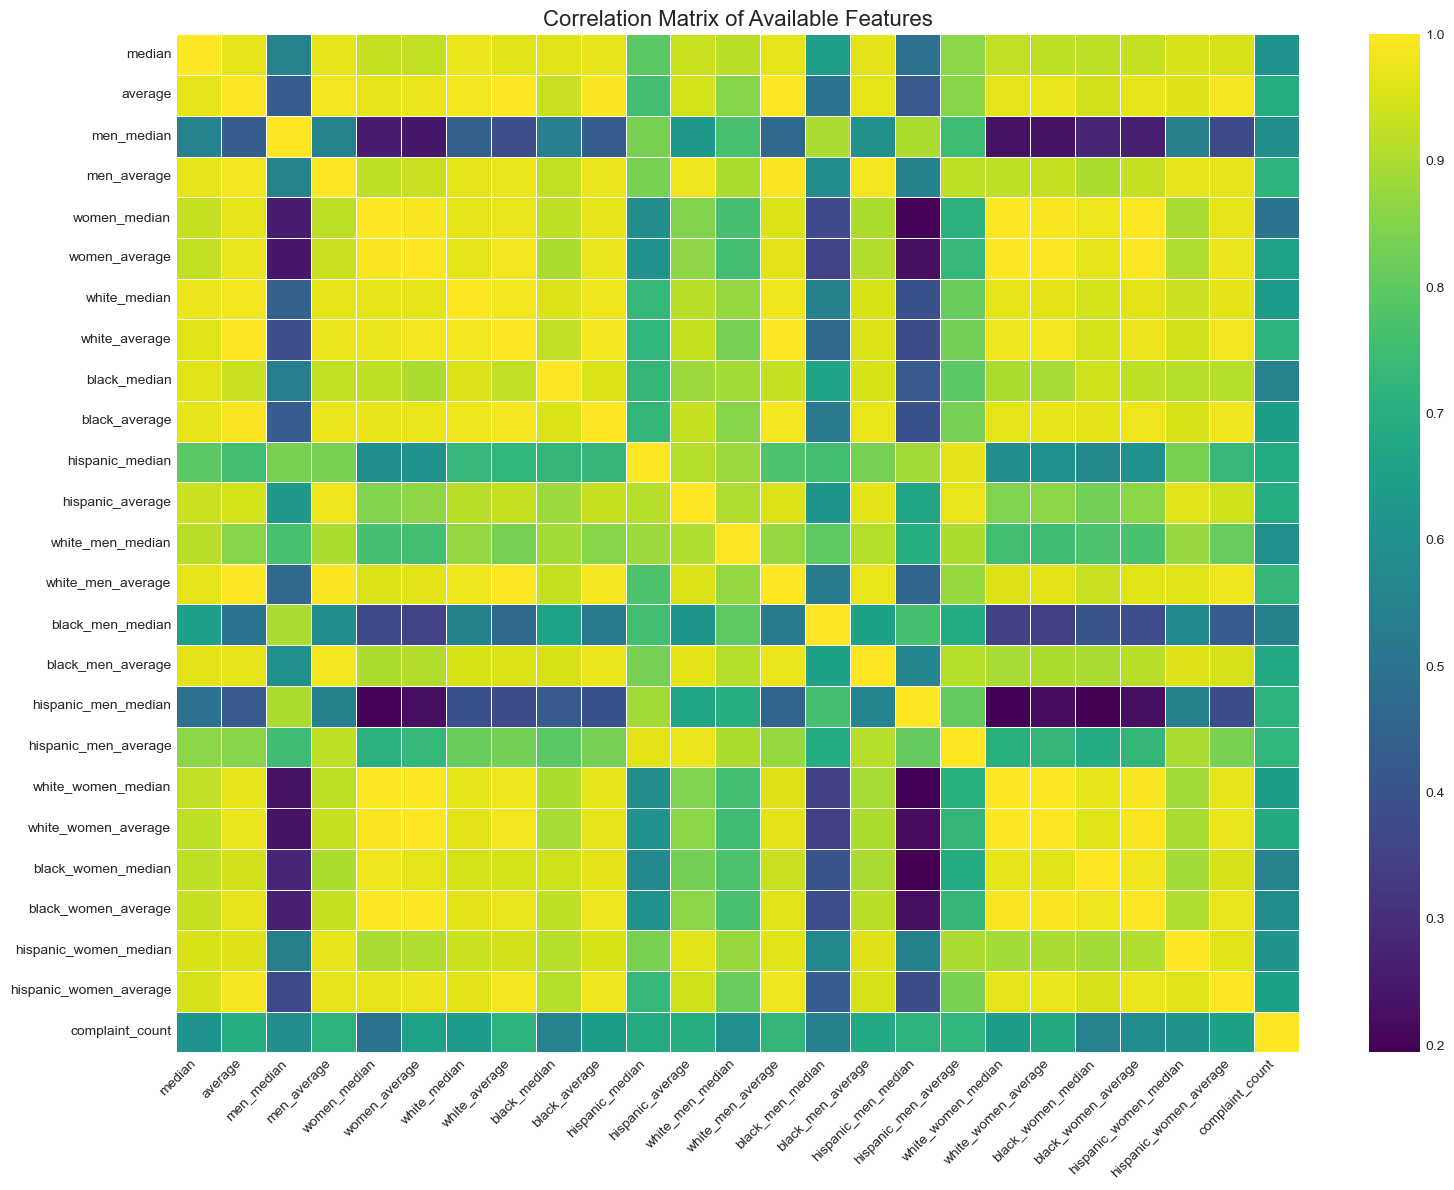

In [43]:
plt.figure(figsize=(16, 12))
numeric_merged_df = merged_df.select_dtypes(include=np.number).dropna(axis=1, how='all')
correlation_matrix = numeric_merged_df.drop(columns=['year'], errors='ignore').corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis', fmt=".1f", linewidths=.5)
plt.title('Correlation Matrix of Available Features', fontsize=16)
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

In [44]:
scatter_features = ['median', 'MEHOIN', 'CCLAC', 'complaint_count']
if num_sod_years > 1 and 'total_deposits' in merged_df.columns:
    scatter_features.append('total_deposits')
elif 'total_deposits' in merged_df.columns:
     print("Deposits check for error, 1 year")

scatter_features = [f for f in scatter_features if f in merged_df.columns]

Deposits check for error, 1 year


Plotting features: ['median', 'complaint_count']


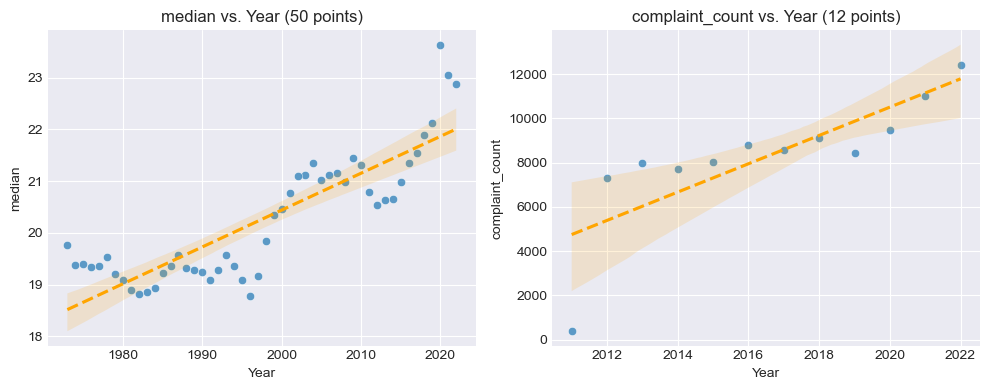

Scatter plots generated.


In [45]:
if scatter_features:
    print(f"Plotting features: {scatter_features}")
    num_plots = len(scatter_features)
    ncols = min(3, num_plots); nrows = int(np.ceil(num_plots / ncols))
    plt.figure(figsize=(ncols * 5, nrows * 4))
    for i, feature in enumerate(scatter_features):
        plt.subplot(nrows, ncols, i + 1)
        valid_points = merged_df[[feature]].dropna().shape[0]
        sns.scatterplot(x='year', y=feature, data=merged_df, alpha=0.7)
        if valid_points > 1:
             sns.regplot(x='year', y=feature, data=merged_df, scatter=False, color='orange', line_kws={'linestyle':'--'})
        plt.title(f'{feature} vs. Year ({valid_points} points)')
        plt.xlabel('Year'); plt.ylabel(feature)
    plt.tight_layout(); plt.show()
    print(f"Scatter plots generated.")
else:
    print("Skipping")

In [46]:
pairplot_features = ['median', 'MEHOIN']
pairplot_cols = [f for f in pairplot_features if f in merged_df.columns]

In [47]:
if len(pairplot_cols) == 2:
  print(f"Selected features for pair plots: {pairplot_cols}")
  print(f"Shape before drop: {merged_df[pairplot_cols].shape}")
  pairplot_data = merged_df[pairplot_cols].dropna()
  print(f"Pairplot shape after: {pairplot_data.shape}")

  if not pairplot_data.empty and pairplot_data.shape[0] > 1:
    print(f"Geneation {pairplot_data.shape[0]}")
    sns.pairplot(pairplot_data, kind='reg', plot_kws={'line_kws':{'color':'orange'}, 'scatter_kws': {'alpha': 0.5}}, diag_kind='kde')
    plt.suptitle('Pair Plot of Median Wage and Median Household Income', y=1.02)
    plt.show()
  else: print("NaNs possible error")
else: print("Check median and mehoin")

Check median and mehoin


In [48]:
def clean_zip(zip_code):
    if pd.isna(zip_code):
        return None
    zip_str = str(zip_code).replace('.0', '')
    match = re.match(r'^\d{5}', zip_str)
    if match:
        return match.group(0)
    return None

In [49]:
try:
    df_sod = pd.read_csv("cleaned_data/sod_clean.csv", low_memory=False)
    df_income = pd.read_csv("cleaned_data/national_income_clean.csv")
    df_complaints = pd.read_csv("cleaned_data/complaints_clean.csv")
    df_wages = pd.read_csv("cleaned_data/median_wages_clean.csv")
    print("Files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure all required files are uploaded.")
    exit()
except Exception as e:
    print(f"An error occurred during file loading: {e}")
    exit()

Files loaded successfully.


In [50]:
if 'ZIP' in df_income.columns:
    df_income = df_income.rename(columns={'ZIP': 'zip_code'})

In [51]:
if 'zip_code' in df_income.columns:
    df_income['zip_code'] = df_income['zip_code'].apply(clean_zip)
    df_income.dropna(subset=['zip_code'], inplace=True) # Remove rows with invalid ZIPs
    # Define target variable
    income_target_col = 'Households - Median income (dollars)'
    if income_target_col in df_income.columns:
        df_income[income_target_col] = safe_to_numeric(df_income[income_target_col])
        # Remove rows where target is missing or non-positive
        df_income = df_income[df_income[income_target_col] > 0]
        print(f"Target variable '{income_target_col}' prepared.")
    else:
        raise ValueError(f"Target income column '{income_target_col}' not found.")
    print(f"Income data shape after cleaning: {df_income.shape}")
else:
    raise ValueError("Column 'zip_code' not found in national_income data.")

Target variable 'Households - Median income (dollars)' prepared.
Income data shape after cleaning: (31195, 58)


In [52]:
if 'zip_code' in df_complaints.columns:
    df_complaints['zip_code'] = df_complaints['zip_code'].apply(clean_zip)
    df_complaints.dropna(subset=['zip_code'], inplace=True)
    if 'date_received' in df_complaints.columns:
         df_complaints['date_received'] = safe_to_datetime(df_complaints['date_received'])
    print(f"Complaints data shape after cleaning ZIP: {df_complaints.shape}")
else:
    raise ValueError("zip error ")

Complaints data shape after cleaning ZIP: (122672, 14)


In [53]:
complaints_agg = df_complaints.groupby('zip_code').size().reset_index(name='complaint_total_count')

In [54]:
top_n_issues = 5
issue_counts = df_complaints.groupby(['zip_code', 'issue_type']).size().unstack(fill_value=0)
top_issues = issue_counts.sum().nlargest(top_n_issues).index
issue_counts_top = issue_counts[top_issues]
issue_counts_top.columns = [f'issue_{c.lower().replace(" ", "_").replace(",", "")[:20]}' for c in issue_counts_top.columns]
complaints_agg = pd.merge(complaints_agg, issue_counts_top, on='zip_code', how='left')

In [55]:
response_col = 'response_type' 
if response_col in df_complaints.columns:
    closed_responses = df_complaints[df_complaints[response_col].str.contains('Closed', case=False, na=False)]
    closed_counts = closed_responses.groupby('zip_code').size().reset_index(name='complaint_closed_count')
    complaints_agg = pd.merge(complaints_agg, closed_counts, on='zip_code', how='left')
    complaints_agg['complaint_closed_count'] = complaints_agg['complaint_closed_count'].fillna(0) 
else:
    print(f"'{response_col}' not found in complaints data.")

In [56]:
if 'branch_zip' in df_sod.columns: 
    df_sod = df_sod.rename(columns={'branch_zip': 'zip_code'})
    df_sod['zip_code'] = df_sod['zip_code'].apply(clean_zip)
    df_sod.dropna(subset=['zip_code'], inplace=True)
    df_sod['year'] = safe_to_numeric(df_sod['year'])
    df_sod['total_deposits'] = safe_to_numeric(df_sod['total_deposits'])

    df_sod_2024 = df_sod[df_sod['year'] == 2024].copy()
    print(f"SOD data shape for 2024: {df_sod_2024.shape}")
else:
    raise ValueError("try something else zip")

SOD data shape for 2024: (69980, 74)


In [57]:
print(f"Aggregated complaints data shape: {complaints_agg.shape}")

Aggregated complaints data shape: (14198, 8)


In [58]:
sod_agg = df_sod_2024.groupby('zip_code').agg(
    sod_total_deposits_24=('total_deposits', 'sum'),
    sod_branch_count_24=('certificate_id', 'nunique') 
).reset_index()
print(f"Sod shape: {sod_agg.shape}")

Sod shape: (16658, 3)


In [59]:
if 'year' in df_wages.columns:
    latest_wage_year = df_wages['year'].max()
    df_wages_latest = df_wages[df_wages['year'] == latest_wage_year].copy()
    df_wages_latest = df_wages_latest.drop(columns=['year'])
    df_wages_latest.columns = [f'wage_natnl_{c}' for c in df_wages_latest.columns]
    if len(df_wages_latest) == 1:
        print(f"Using national wages data from year {latest_wage_year}.")
    else:
        print(f"clash {latest_wage_year}.")
        df_wages_latest = df_wages_latest.mean().to_frame().T 

else:
    df_wages_latest = pd.DataFrame()

Using national wages data from year 2022.


In [60]:
merged_df = df_income

print(f"complaints shape {complaints_agg.shape}")
merged_df = pd.merge(merged_df, complaints_agg, on='zip_code', how='left')
count_cols = [col for col in complaints_agg.columns if col not in ['zip_code']]
merged_df[count_cols] = merged_df[count_cols].fillna(0)

complaints shape (14198, 8)


In [61]:
print(f"Merge sod shape {sod_agg.shape}")
merged_df = pd.merge(merged_df, sod_agg, on='zip_code', how='left')
sod_cols = [col for col in sod_agg.columns if col not in ['zip_code']]
merged_df[sod_cols] = merged_df[sod_cols].fillna(0)

Merge sod shape (16658, 3)


In [62]:
if not df_wages_latest.empty:
    print(f"wage national shape {df_wages_latest.shape}")
    for col in df_wages_latest.columns:
        merged_df[col] = df_wages_latest[col].iloc[0]

wage national shape (1, 24)


In [63]:
print(f"Final shape  {merged_df.shape}")
print(merged_df.info())

Final shape  (31195, 91)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31195 entries, 0 to 31194
Data columns (total 91 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   zip_code                                           31195 non-null  object 
 1   Town                                               31195 non-null  object 
 2   State Abbreviation                                 31195 non-null  object 
 3   State                                              31195 non-null  object 
 4   Metro                                              31195 non-null  object 
 5   Primary County                                     31195 non-null  object 
 6   Total population                                   31195 non-null  int64  
 7   Households - Median income (dollars)               31195 non-null  float64
 8   Families - Median income (dollars)                 31195 non-

In [64]:
TARGET = income_target_col
numeric_features = merged_df.select_dtypes(include=np.number).columns.tolist()
numeric_features = [col for col in numeric_features if col not in [TARGET, 'zip_code', 'year']]

In [65]:
categorical_features = merged_df.select_dtypes(include='object').columns.tolist()
categorical_features = [col for col in categorical_features if col not in ['zip_code']]
categorical_features = [col for col in categorical_features if col == 'Metro']

In [66]:
print(f"Target: {TARGET}")
print(f"Numeric Features ({len(numeric_features)}): {numeric_features[:5]}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")

Target: Households - Median income (dollars)
Numeric Features (84): ['Total population', 'Families - Median income (dollars)', 'Married-couple families - Median income (dollars)', 'Nonfamily households - Median income (dollars)', 'Households - Mean income (dollars)']
Categorical Features (1): ['Metro']


In [67]:
X = merged_df[numeric_features + categorical_features]
y = merged_df[TARGET]
X = X.replace([np.inf, -np.inf], np.nan)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (24956, 85), Test shape: (6239, 85)


In [69]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [70]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Total population',
                                                   'Families - Median income '
                                                   '(dollars)',
                                                   'Married-couple families - '
                                                   'Median income (dollars)',
                                                   'Nonfamily households - '
                                                   'Median income (dollars)',
                                                   'Households - Mea...
                                                   'Families - $50,000 to '
                                                   '$74,999',
                                                   'Families - $75,000 to '
                                                   '$99,999',
                                                   'Families - $100,000 to '
                                                   '$149,999',
                                                   'Families - $150,000 to '
                                                   '$199,999',
                                                   'Families - $200,000 or '
                                                   'more',
                                                   'Married-couple families - '
                                                   'Total', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Metro'])])),
                ('regressor', LinearRegression())])

In [71]:
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

In [72]:
print(f"R^2: {r2_score(y_train, y_pred_train):.3f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.3f}")

R^2: 0.854
MAE: 6148.149
RMSE: 10646.764


In [73]:
print(f"R^#: {r2_score(y_test, y_pred_test):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.3f}")

R^#: 0.834
MAE: 6421.071
RMSE: 11321.262


In [74]:
plt.style.use('ggplot')

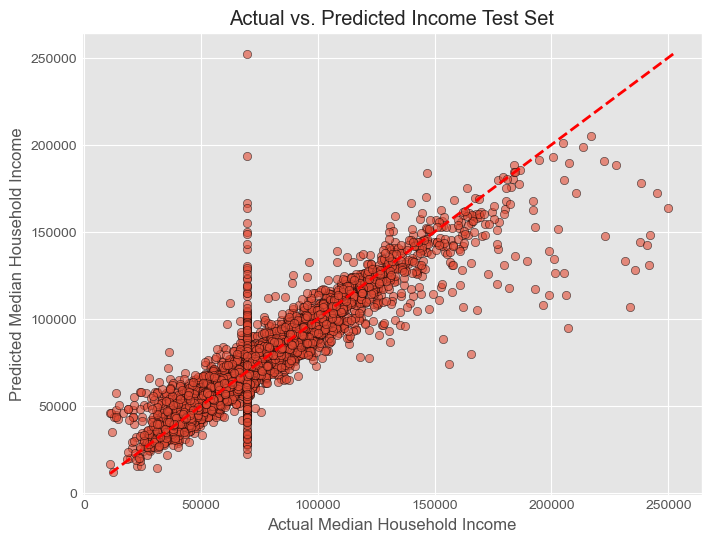

In [75]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, edgecolors='k')
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', lw=2, color='red')
plt.xlabel("Actual Median Household Income")
plt.ylabel("Predicted Median Household Income")
plt.title("Actual vs. Predicted Income Test Set")
plt.grid(True)
plt.show()

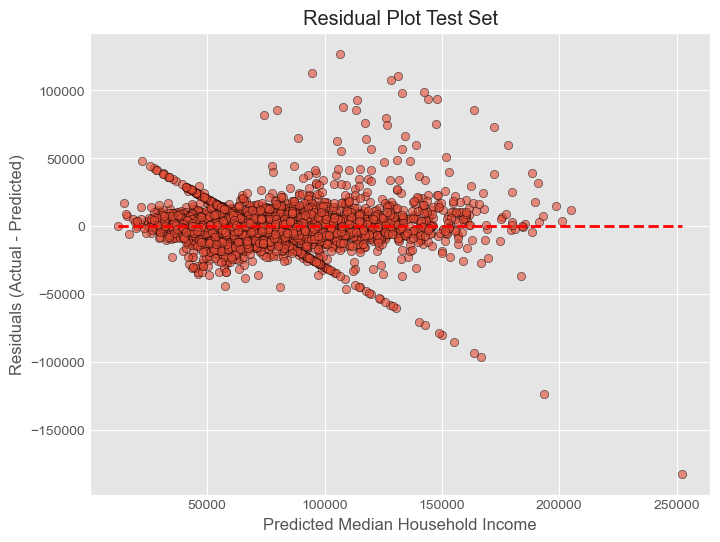

In [76]:
residuals = y_test - y_pred_test
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, alpha=0.6, edgecolors='k')
plt.hlines(0, xmin=y_pred_test.min(), xmax=y_pred_test.max(), linestyles='--', lw=2, color='red')
plt.xlabel("Predicted Median Household Income")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot Test Set")
plt.grid(True)
plt.show()

Top Features
                                Feature   Coefficient  Abs_Coefficient
17        Households - $200,000 or more  18241.379090     18241.379090
15    Households - $100,000 to $149,999  15355.142792     15355.142792
770              Metro_Rock Springs, WY -13451.549888     13451.549888
28          Families - $200,000 or more -13066.371990     13066.371990
894             Metro_Town of Pecos, TX  12851.868390     12851.868390
16    Households - $150,000 to $199,999  12736.458532     12736.458532
389   Metro_Gardnerville Ranchos, NV-CA -12684.815019     12684.815019
470                Metro_Jackson, WY-ID -12573.860054     12573.860054
916                    Metro_Vernon, TX  12569.305575     12569.305575
1    Families - Median income (dollars)  12099.708933     12099.708933


C:\Users\ncpr0\AppData\Local\Temp\ipykernel_14308\1513284903.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(n_plot), palette='coolwarm')


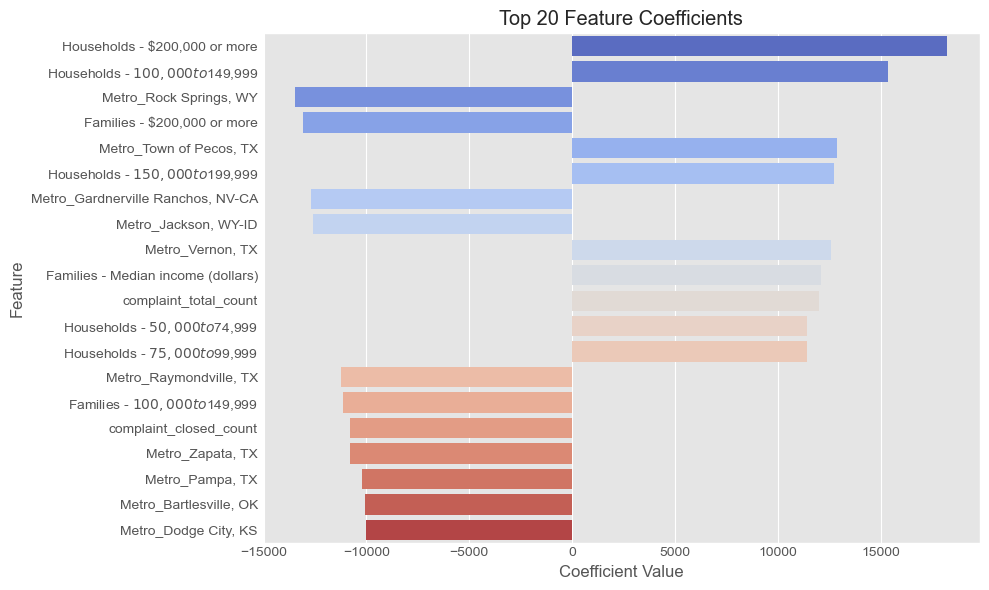

In [77]:
try:
    cat_feature_names = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(cat_feature_names)

    coefficients = model_pipeline.named_steps['regressor'].coef_

    if len(all_feature_names) == len(coefficients):
        coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
        coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
        coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
        print("Top Features")
        print(coef_df.head(10))
        n_plot = 20
        plt.figure(figsize=(10, max(6, n_plot * 0.3)))
        sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(n_plot), palette='coolwarm')
        plt.title(f'Top {n_plot} Feature Coefficients')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

    else:
        print(f"Possible mismatch for names {len(all_feature_names)} {len(coefficients)}")

except Exception as e:
    print(f"Error dont know why: {e}")

In [78]:
if 'complaint_total_count' in merged_df.columns:
     correlation = merged_df[TARGET].corr(merged_df['complaint_total_count'])
     print(f"Median income & Total complaints correlation: {correlation:.3f}")

Median income & Total complaints correlation: 0.258


In [79]:
if 'complaint_closed_count' in merged_df.columns:
     correlation_closed = merged_df[TARGET].corr(merged_df['complaint_closed_count'])
     print(f"Correlation between median income and complaints leading to closed accounts: {correlation_closed:.3f}")

Correlation between median income and complaints leading to closed accounts: 0.258


In [80]:
if not issue_counts_top.empty:
    print("\nAverage Median Income for ZIP codes where top issues occurred:")
    merged_issues = pd.merge(df_income[['zip_code', TARGET]], issue_counts_top.reset_index(), on='zip_code', how='inner')
    for issue_col in issue_counts_top.columns:
         avg_income = merged_issues[merged_issues[issue_col] > 0][TARGET].mean()
         print(f"  - Avg. Income for '{issue_col.replace('issue_', '')}': ${avg_income:,.2f}")


Average Median Income for ZIP codes where top issues occurred:
  - Avg. Income for 'managing_an_account': $89,255.65
  - Avg. Income for 'loan_modificationcol': $89,333.92
  - Avg. Income for 'problem_with_a_purch': $94,341.45
  - Avg. Income for 'incorrect_informatio': $87,576.18
  - Avg. Income for 'improper_use_of_your': $84,505.90


# <span> Classification Model: Random Forest</span>

In [82]:
def safe_to_numeric(series): return pd.to_numeric(series, errors='coerce')

def clean_zip_code(zip_code):
    if pd.isna(zip_code):
        return None
    zip_str = str(zip_code).split('.')[0]
    zip_digits = ''.join(filter(str.isdigit, zip_str))
    if len(zip_digits) < 5:
         return zip_digits.zfill(5)
    elif len(zip_digits) > 5:
         return zip_digits[:5]
    return zip_digits

In [83]:
print("Available plotting styles:", plt.style.available)
plotting_style = 'seaborn-v0_8-darkgrid'
if plotting_style not in plt.style.available:
    print(f"Warning: Style '{plotting_style}' not found, using 'ggplot'.")
    plotting_style = 'ggplot'
    if plotting_style not in plt.style.available:
        print(f"Warning: Style 'ggplot' not found, using default.")
        plotting_style = 'default'

Available plotting styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [84]:
df_complaints = pd.read_csv("cleaned_data/complaints_clean.csv")
df_national_income = pd.read_csv("cleaned_data/national_income_clean.csv")

In [85]:
complaint_zip_col = 'zip_code'
complaint_product_col = 'product_type'
complaint_issue_col = 'issue_type'

In [86]:
if complaint_zip_col not in df_complaints.columns: raise ValueError(f"Column '{complaint_zip_col}' not found in complaints data.")
if complaint_product_col not in df_complaints.columns: print(f"Warning: Column '{complaint_product_col}' not found.")
if complaint_issue_col not in df_complaints.columns: print(f"Warning: Column '{complaint_issue_col}' not found.")

In [87]:
df_complaints['zip_code_clean'] = df_complaints[complaint_zip_col].apply(clean_zip_code)
df_complaints.dropna(subset=['zip_code_clean'], inplace=True)
print(f"Complaints shape after cleaning ZIPs: {df_complaints.shape}")

Complaints shape after cleaning ZIPs: (139944, 15)


In [88]:
complaints_agg_list = []
count_agg = df_complaints.groupby('zip_code_clean').size().reset_index(name='complaint_count')
complaints_agg_list.append(count_agg)

In [89]:
if complaint_product_col in df_complaints.columns:
    mode_product = df_complaints.groupby('zip_code_clean')[complaint_product_col].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').reset_index()
    mode_product = mode_product.rename(columns={complaint_product_col: 'mode_product_type'})
    complaints_agg_list.append(mode_product)

In [90]:
if complaint_issue_col in df_complaints.columns:
    mode_issue = df_complaints.groupby('zip_code_clean')[complaint_issue_col].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').reset_index()
    mode_issue = mode_issue.rename(columns={complaint_issue_col: 'mode_issue_type'})
    complaints_agg_list.append(mode_issue)

In [91]:
if len(complaints_agg_list) > 1:
    complaints_agg_merged = complaints_agg_list[0]
    for i in range(1, len(complaints_agg_list)):
        complaints_agg_merged = pd.merge(complaints_agg_merged, complaints_agg_list[i], on='zip_code_clean', how='outer')
    if 'complaint_count' in complaints_agg_merged.columns:
        complaints_agg_merged['complaint_count'] = complaints_agg_merged['complaint_count'].fillna(0)
    if 'mode_product_type' in complaints_agg_merged.columns:
        complaints_agg_merged['mode_product_type'] = complaints_agg_merged['mode_product_type'].fillna('Unknown')
    if 'mode_issue_type' in complaints_agg_merged.columns:
        complaints_agg_merged['mode_issue_type'] = complaints_agg_merged['mode_issue_type'].fillna('Unknown')
elif complaints_agg_list: complaints_agg_merged = complaints_agg_list[0]
else: raise ValueError("Could not aggregate any complaint features")

In [92]:
print(f"Aggregated complaints features shape: {complaints_agg_merged.shape}")

Aggregated complaints features shape: (14945, 4)


In [93]:
income_zip_col = 'ZIP'
pop_col = 'Total population'

In [94]:
if income_zip_col not in df_national_income.columns: raise ValueError(f"Column '{income_zip_col}' not found.")
if pop_col not in df_national_income.columns: raise ValueError(f"Population column '{pop_col}' not found.")

df_national_income['zip_code_clean'] = df_national_income[income_zip_col].apply(clean_zip_code)
df_national_income.dropna(subset=['zip_code_clean'], inplace=True)

In [95]:
income_cols = [col for col in df_national_income.columns if 'income' in col.lower()]
relevant_cols = ['zip_code_clean', pop_col] + income_cols
relevant_cols = [col for col in relevant_cols if col in df_national_income.columns]
df_income_subset = df_national_income[relevant_cols].copy()

In [96]:
for col in income_cols:
    if col in df_income_subset.columns: df_income_subset[col] = safe_to_numeric(df_income_subset[col])
if pop_col in df_income_subset.columns: df_income_subset[pop_col] = safe_to_numeric(df_income_subset[pop_col])

In [97]:
df_income_subset.drop_duplicates(subset=['zip_code_clean'], keep='first', inplace=True)
print(f"Income subset shape after dropping duplicates: {df_income_subset.shape}")

Income subset shape after dropping duplicates: (33772, 9)


In [98]:
merged_df = pd.merge(df_income_subset, complaints_agg_merged, on='zip_code_clean', how='outer')
print(f"Merged data shape (outer): {merged_df.shape}")

Merged data shape (outer): (35652, 12)


In [99]:
if 'complaint_count' in merged_df.columns:
    merged_df['complaint_count'] = merged_df['complaint_count'].fillna(0)
if 'mode_product_type' in merged_df.columns:
    merged_df['mode_product_type'] = merged_df['mode_product_type'].fillna('None')
if 'mode_issue_type' in merged_df.columns:
    merged_df['mode_issue_type'] = merged_df['mode_issue_type'].fillna('None')

In [100]:
if pop_col in merged_df.columns and 'complaint_count' in merged_df.columns:
    merged_df[pop_col] = merged_df[pop_col].replace(0, np.nan)
    merged_df['complaints_per_capita'] = merged_df['complaint_count'] / merged_df[pop_col]
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    non_missing_per_capita = merged_df['complaints_per_capita'].dropna()
    if len(non_missing_per_capita) > 0:
        try:
             categories = pd.qcut(non_missing_per_capita, q=3, labels=['Low', 'Medium', 'High'])
             merged_df.loc[categories.index, 'complaint_rate_category'] = categories
             print("Category distribution:\n", merged_df['complaint_rate_category'].value_counts())
        except ValueError as e:
             print(f"Could not create categories using qcut: {e}. just creating binary ")
             median_rate = non_missing_per_capita.median()
             categories = np.where(merged_df['complaints_per_capita'] <= median_rate, 'Low', 'High')
             merged_df.loc[merged_df['complaints_per_capita'].notna(), 'complaint_rate_category'] = categories[merged_df['complaints_per_capita'].notna()]

    else:
        raise ValueError("No valid 'complaints_per_capita' values to create categories from.")

    initial_rows = merged_df.shape[0]
    merged_df.dropna(subset=['complaint_rate_category'], inplace=True)
    rows_dropped = initial_rows - merged_df.shape[0]
    print(f"Created target category. Dropped {rows_dropped} rows with missing category assignment.")
    print(f"Shape after creating target category: {merged_df.shape}")
else:
    raise ValueError(f"Required columns ('{pop_col}', 'complaint_count') not found for target calculation.")

Could not create categories using qcut: Bin edges must be unique: Index([0.0, 0.0, 0.00012245147860160408, 0.3333333333333333], dtype='float64', name='complaints_per_capita').
You can drop duplicate edges by setting the 'duplicates' kwarg. just creating binary 
Created target category. Dropped 2471 rows with missing category assignment.
Shape after creating target category: (33181, 14)


In [101]:
if merged_df.shape[0] < 2: raise ValueError("Insufficient data after creating target category.")
target = 'complaint_rate_category'
features_to_exclude = ['zip_code_clean', 'complaint_count', pop_col, 'complaints_per_capita', target]
potential_feature_cols = [col for col in merged_df.columns if col not in features_to_exclude]

In [102]:
X = merged_df[potential_feature_cols]
y = merged_df[target]

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

In [103]:
print(f"Target variable: {target} (Categorical)")
print(f"Using {len(numeric_features)} numeric features.")
print(f"Using {len(categorical_features)} categorical features: {categorical_features}")

Target variable: complaint_rate_category (Categorical)
Using 7 numeric features.
Using 2 categorical features: ['mode_product_type', 'mode_issue_type']


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [105]:
print(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

Train set shape: X=(26544, 9), y=(26544,)
Test set shape: X=(6637, 9), y=(6637,)
Train target distribution:
 complaint_rate_category
Low     0.607331
High    0.392669
Name: proportion, dtype: float64
Test target distribution:
 complaint_rate_category
Low     0.607353
High    0.392647
Name: proportion, dtype: float64


In [106]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])

In [107]:
pipeline.fit(X_train, y_train)
y_pred_test = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nTest Set Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_test, zero_division=0))


Test Set Accuracy: 1.0000
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      2606
         Low       1.00      1.00      1.00      4031

    accuracy                           1.00      6637
   macro avg       1.00      1.00      1.00      6637
weighted avg       1.00      1.00      1.00      6637



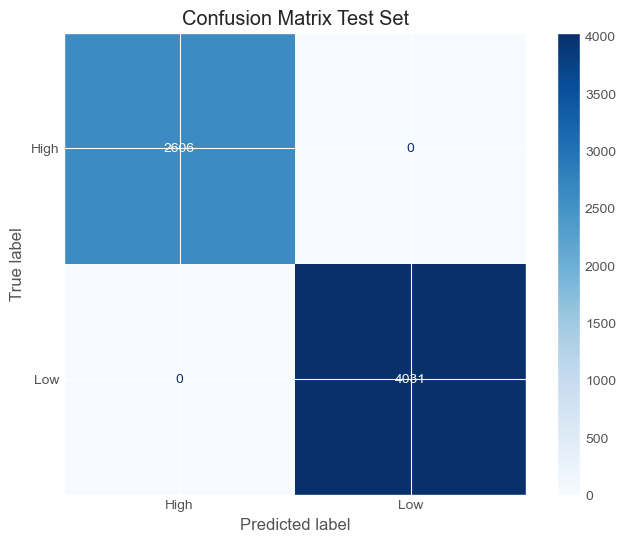

In [108]:
try:
    cm = confusion_matrix(y_test, y_pred_test, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.show()
except Exception as e:
    print(f"Could not plot confusion matrix: {e}")

C:\Users\ncpr0\AppData\Local\Temp\ipykernel_14308\2918586805.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(n_top_features), palette='viridis')


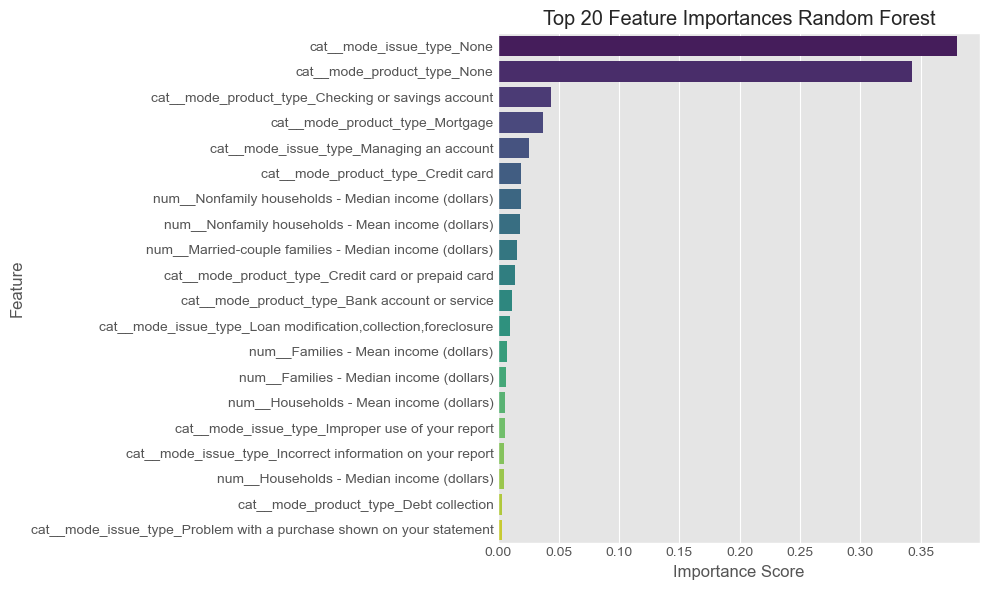

                                                                  Feature  Importance
93                                              cat__mode_issue_type_None    0.380058
20                                            cat__mode_product_type_None    0.342475
8                      cat__mode_product_type_Checking or savings account    0.043961
19                                        cat__mode_product_type_Mortgage    0.037196
89                               cat__mode_issue_type_Managing an account    0.025258
10                                     cat__mode_product_type_Credit card    0.018996
3                     num__Nonfamily households - Median income (dollars)    0.018562
6                       num__Nonfamily households - Mean income (dollars)    0.017583
2                  num__Married-couple families - Median income (dollars)    0.015696
11                     cat__mode_product_type_Credit card or prepaid card    0.013603
7                          cat__mode_product_type_Bank

In [109]:
try:
    feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = pipeline.named_steps['classifier'].feature_importances_

    if len(feature_names_out) == len(importances):
        importance_df = pd.DataFrame({'Feature': feature_names_out, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)

        n_top_features = 20
        plt.figure(figsize=(10, max(6, len(importance_df.head(n_top_features)) * 0.3)))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(n_top_features), palette='viridis')
        plt.title(f'Top {n_top_features} Feature Importances Random Forest')
        plt.xlabel('Importance Score'); plt.ylabel('Feature')
        plt.tight_layout(); plt.show()
        print(importance_df.head(n_top_features).to_string())
    else:
        print(f"Feature names count: {len(feature_names_out)}")
        print(f"Importances count: {len(importances)}")

except Exception as e:
    print(f"Could not extract or plot feature importances: {e}")

In [110]:
importance_df = pd.DataFrame() # Initialize
top_numeric_features = []
try:
    feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = pipeline.named_steps['classifier'].feature_importances_
    if len(feature_names_out) == len(importances):
        importance_df = pd.DataFrame({'Feature': feature_names_out, 'Importance': importances})
        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        # Get top 1 or 2 NUMERIC feature names for later plots
        num_transformer_features = pipeline.named_steps['preprocessor'].transformers_[0][2]
        for feature_name in importance_df['Feature']:
             original_feature = feature_name.split('__')[-1]
             if feature_name.startswith('num__') and original_feature in num_transformer_features:
                  top_numeric_features.append(original_feature)
             if len(top_numeric_features) >= 2: break
        if not top_numeric_features and num_transformer_features: top_numeric_features = num_transformer_features[:1]
        print(f"Selected top numeric features for plots: {top_numeric_features}")
    else: print("Warning: Mismatch between feature names and importances.")
except Exception as e: print(f"Could not extract feature importances: {e}")
if not top_numeric_features: # Fallback if extraction failed
     top_numeric_features = [f for f in numeric_features if f in merged_df.columns][:2]

Selected top numeric features for plots: ['Nonfamily households - Median income (dollars)', 'Nonfamily households - Mean income (dollars)']


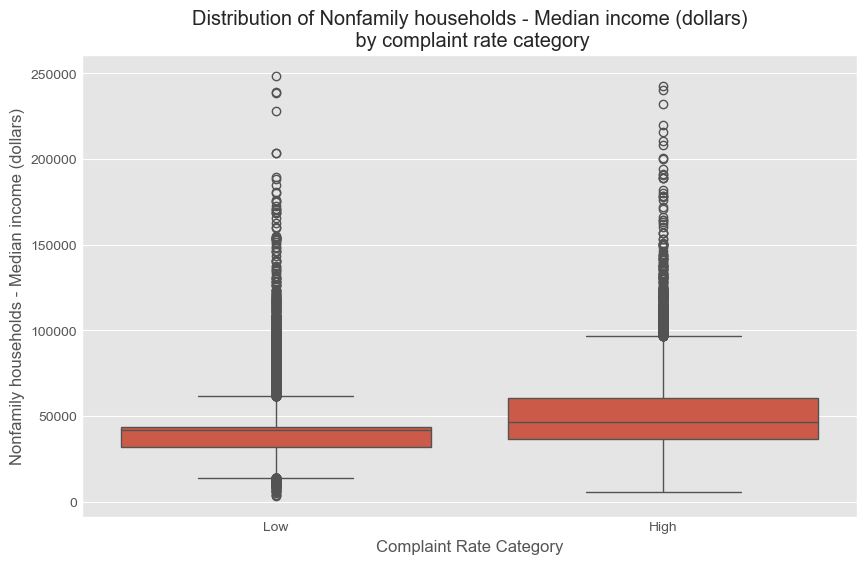

In [111]:
if top_numeric_features and target in merged_df.columns:
    top_feature_to_plot = top_numeric_features[0]
    if top_feature_to_plot in merged_df.columns:
        plt.figure(figsize=(10, 6))
        plot_data = merged_df[[top_feature_to_plot, target]].copy()
        category_order = ['Low', 'Medium', 'High']
        available_categories = [c for c in category_order if c in plot_data[target].unique()]
        if available_categories:
             plot_data[target] = pd.Categorical(plot_data[target], categories=available_categories, ordered=True)
        sns.boxplot(x=target, y=top_feature_to_plot, data=plot_data, order=available_categories)
        plt.title(f'Distribution of {top_feature_to_plot}\n by complaint rate category')
        plt.xlabel('Complaint Rate Category'); plt.ylabel(top_feature_to_plot)
        plt.show()
    else: print(f"Box plot cant find error '{top_feature_to_plot}")
else: print("Error for box plot, cant display")

Loading features: ['Nonfamily households - Median income (dollars)', 'Nonfamily households - Mean income (dollars)']


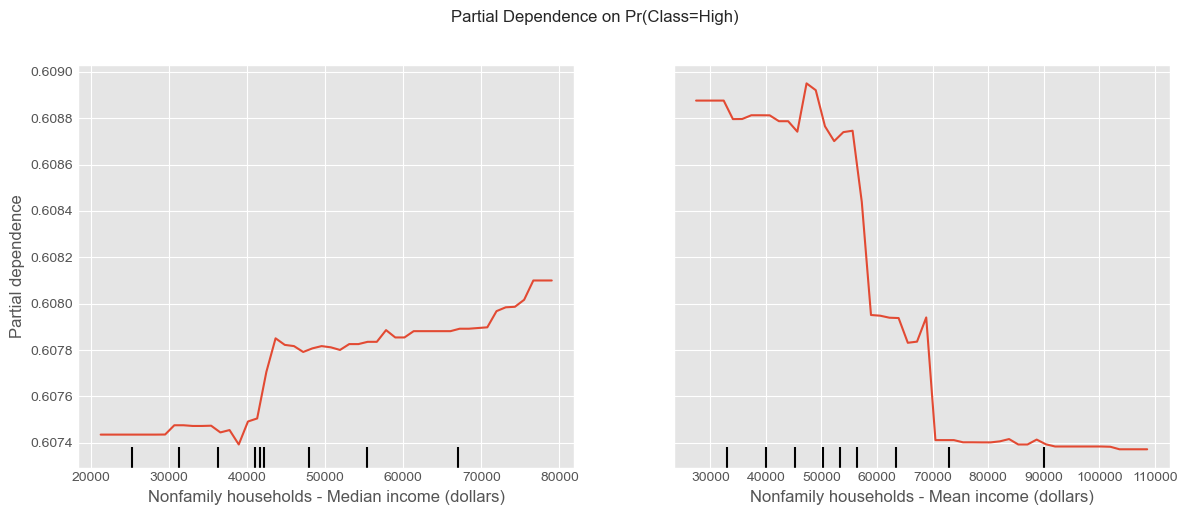

In [112]:
if top_numeric_features and 'pipeline' in locals() and 'X_train' in locals() and hasattr(pipeline, 'classes_'):
     features_for_pdp = [f for f in top_numeric_features[:2] if f in X_train.columns]
     print(f"Loading features: {features_for_pdp}")
     if features_for_pdp:
        target_class_idx = -1; target_class_name = 'High'
        classes_list = list(pipeline.classes_)
        if target_class_name in classes_list: target_class_idx = classes_list.index(target_class_name)
        elif len(classes_list) > 0: target_class_idx = len(classes_list) - 1; target_class_name = classes_list[target_class_idx]; print(f"Class error {target_class_name}")

        if target_class_idx != -1:
            try:
                 fig, ax = plt.subplots(figsize=(len(features_for_pdp) * 6, 5))
                 if len(features_for_pdp) == 1: ax = [ax]
                 display = PartialDependenceDisplay.from_estimator(
                     pipeline, X_train, features=features_for_pdp,
                     target=target_class_idx, grid_resolution=50,
                     random_state=42, n_jobs=-1, percentiles=(0.05, 0.95),
                     ax=ax
                 )
                 plt.suptitle(f'Partial Dependence on Pr(Class={target_class_name})', y=1.02)
                 if len(features_for_pdp) > 1: display.figure_.tight_layout()
                 else: plt.tight_layout() 
                 plt.show()
            except Exception as e: print(f"-> Could not generate PDP: {e}")
        else: print("Possible index error")
     else: print("maybe x_train?")
else: print("feature error")

# <span>Neural Network: Multilayer Perceptron</span>

In [114]:
def safe_to_numeric(series): return pd.to_numeric(series, errors='coerce')

def clean_zip_code(zip_code):
    """Cleans ZIP code: converts to string, removes non-digits, pads to 5 digits."""
    if pd.isna(zip_code): return None
    zip_str = str(zip_code).split('.')[0]
    zip_digits = ''.join(filter(str.isdigit, zip_str))
    if len(zip_digits) < 5: return zip_digits.zfill(5)
    elif len(zip_digits) > 5: return zip_digits[:5]
    return zip_digits

In [115]:
print("Available plotting styles:", plt.style.available)
plotting_style = 'seaborn-v0_8-darkgrid'
if plotting_style not in plt.style.available:
    print(f"Warning: Style '{plotting_style}' not found, using 'ggplot'.")
    plotting_style = 'ggplot'
    if plotting_style not in plt.style.available:
        print(f"Warning: Style 'ggplot' not found, using default.")
        plotting_style = 'default'
plt.style.use(plotting_style)
print(f"Using plotting style: '{plotting_style}'")

Available plotting styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Using plotting style: 'seaborn-v0_8-darkgrid'


In [116]:
df_complaints = pd.read_csv("cleaned_data/complaints_clean.csv")
df_national_income = pd.read_csv("cleaned_data/national_income_clean.csv")

In [117]:
print("\nProcessing complaints data...")
complaint_zip_col = 'zip_code'; complaint_product_col = 'product_type'; complaint_issue_col = 'issue_type'
if complaint_zip_col not in df_complaints.columns: raise ValueError(f"'{complaint_zip_col}' not found.")
df_complaints['zip_code_clean'] = df_complaints[complaint_zip_col].apply(clean_zip_code)
df_complaints.dropna(subset=['zip_code_clean'], inplace=True)
complaints_agg_list = []
count_agg = df_complaints.groupby('zip_code_clean').size().reset_index(name='complaint_count')
complaints_agg_list.append(count_agg)


Processing complaints data...


In [118]:
if complaint_product_col in df_complaints.columns:
    mode_product = df_complaints.groupby('zip_code_clean')[complaint_product_col].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').reset_index().rename(columns={complaint_product_col: 'mode_product_type'})
    complaints_agg_list.append(mode_product)

In [119]:
if complaint_issue_col in df_complaints.columns:
    mode_issue = df_complaints.groupby('zip_code_clean')[complaint_issue_col].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Unknown').reset_index().rename(columns={complaint_issue_col: 'mode_issue_type'})
    complaints_agg_list.append(mode_issue)

In [120]:
if len(complaints_agg_list) > 1:
    complaints_agg_merged = complaints_agg_list[0]
    for i in range(1, len(complaints_agg_list)): complaints_agg_merged = pd.merge(complaints_agg_merged, complaints_agg_list[i], on='zip_code_clean', how='outer')
    if 'complaint_count' in complaints_agg_merged.columns: complaints_agg_merged['complaint_count'] = complaints_agg_merged['complaint_count'].fillna(0)
    if 'mode_product_type' in complaints_agg_merged.columns: complaints_agg_merged['mode_product_type'] = complaints_agg_merged['mode_product_type'].fillna('Unknown')
    if 'mode_issue_type' in complaints_agg_merged.columns: complaints_agg_merged['mode_issue_type'] = complaints_agg_merged['mode_issue_type'].fillna('Unknown')
elif complaints_agg_list: complaints_agg_merged = complaints_agg_list[0]
else: raise ValueError("No complaint features aggregated.")

In [121]:
income_zip_col = 'ZIP'; pop_col = 'Total population'
if income_zip_col not in df_national_income.columns: raise ValueError(f"'{income_zip_col}' not found.")
if pop_col not in df_national_income.columns: raise ValueError(f"'{pop_col}' not found.")
df_national_income['zip_code_clean'] = df_national_income[income_zip_col].apply(clean_zip_code)
df_national_income.dropna(subset=['zip_code_clean'], inplace=True)
income_cols = [col for col in df_national_income.columns if 'income' in col.lower()]
relevant_cols = ['zip_code_clean', pop_col] + income_cols
relevant_cols = [col for col in relevant_cols if col in df_national_income.columns]
df_income_subset = df_national_income[relevant_cols].copy()
for col in income_cols:
    if col in df_income_subset.columns: df_income_subset[col] = safe_to_numeric(df_income_subset[col])
if pop_col in df_income_subset.columns: df_income_subset[pop_col] = safe_to_numeric(df_income_subset[pop_col])
df_income_subset.drop_duplicates(subset=['zip_code_clean'], keep='first', inplace=True)

In [122]:
merged_df = pd.merge(df_income_subset, complaints_agg_merged, on='zip_code_clean', how='outer')
if 'complaint_count' in merged_df.columns: merged_df['complaint_count'] = merged_df['complaint_count'].fillna(0)
if 'mode_product_type' in merged_df.columns: merged_df['mode_product_type'] = merged_df['mode_product_type'].fillna('None')
if 'mode_issue_type' in merged_df.columns: merged_df['mode_issue_type'] = merged_df['mode_issue_type'].fillna('None')
print(f"Merged shape: {merged_df.shape}")

Merged shape: (35652, 12)


In [123]:
if pop_col in merged_df.columns and 'complaint_count' in merged_df.columns:
    merged_df[pop_col] = merged_df[pop_col].replace(0, np.nan)
    merged_df['complaints_per_capita'] = merged_df['complaint_count'] / merged_df[pop_col]
    merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    non_missing_per_capita = merged_df['complaints_per_capita'].dropna()
    if len(non_missing_per_capita) > 0:
         median_rate = non_missing_per_capita.median()
         categories = np.where(merged_df['complaints_per_capita'] <= median_rate, 'Low', 'High')
         merged_df.loc[merged_df['complaints_per_capita'].notna(), 'complaint_rate_category'] = categories[merged_df['complaints_per_capita'].notna()]
         print("Category distribution (Binary):\n", merged_df['complaint_rate_category'].value_counts())
    else: raise ValueError("No valid per capita values.")
    merged_df.dropna(subset=['complaint_rate_category'], inplace=True)
else: raise ValueError("Required columns missing for target calculation.")
if merged_df.shape[0] < 2: raise ValueError("Insufficient data.")
print(f"Final shape for modeling: {merged_df.shape}")

Category distribution (Binary):
 complaint_rate_category
Low     20152
High    13029
Name: count, dtype: int64
Final shape for modeling: (33181, 14)


In [124]:
target = 'complaint_rate_category'
features_to_exclude = ['zip_code_clean', 'complaint_count', pop_col, 'complaints_per_capita', target]
potential_feature_cols = [col for col in merged_df.columns if col not in features_to_exclude]

In [125]:
X = merged_df[potential_feature_cols]
y_raw = merged_df[target]

# Encode the target variable ('Low' -> 0, 'High' -> 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
print(f"Target variable encoded. Classes: {label_encoder.classes_} -> {np.unique(y)}")

Target variable encoded. Classes: ['High' 'Low'] -> [0 1]


In [126]:
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

In [127]:
print(f"Using {len(numeric_features)} numeric features.")
print(f"Using {len(categorical_features)} categorical features: {categorical_features}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

Using 7 numeric features.
Using 2 categorical features: ['mode_product_type', 'mode_issue_type']
Train set shape: X=(26544, 9), y=(26544,)
Test set shape: X=(6637, 9), y=(6637,)


In [128]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [129]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')

In [130]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed test data shape: {X_test_processed.shape}")

Processed training data shape: (26544, 142)
Processed test data shape: (6637, 142)


In [131]:
n_features = X_train_processed.shape[1]
print(f"Number of features after preprocessing: {n_features}")

Number of features after preprocessing: 142


In [132]:
tf.random.set_seed(42)

In [133]:
model = keras.Sequential(
    [
        layers.Input(shape=(n_features,), name="Input_Layer"),
        layers.Dense(64, activation="relu", name="Hidden_Layer_1"),
        layers.Dropout(0.3, name="Dropout_1"), 
        layers.Dense(32, activation="relu", name="Hidden_Layer_2"),
        layers.Dropout(0.2, name="Dropout_2"),
        layers.Dense(1, activation="sigmoid", name="Output_Layer") 
    ],
    name="Complaint_Classifier_MLP"
)

In [134]:
model.summary()

Model: "Complaint_Classifier_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 64)             │         9,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,265 (44.00 KB)

 Trainable params: 11,265 (44.00 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

In [136]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10,        
    restore_best_weights=True 
)

In [137]:
history = model.fit(
    X_train_processed,
    y_train,
    epochs=100, 
    batch_size=64,
    validation_split=0.2, 
    callbacks=[early_stopping],
    verbose=1 
)

Epoch 1/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8834 - loss: 0.2627 - val_accuracy: 1.0000 - val_loss: 8.1767e-04
Epoch 2/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9998 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 1.1847e-04
Epoch 3/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.8014e-04 - val_accuracy: 1.0000 - val_loss: 3.6708e-05
Epoch 4/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9999 - loss: 4.5861e-04 - val_accuracy: 1.0000 - val_loss: 1.7336e-05
Epoch 5/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.3721e-04 - val_accuracy: 1.0000 - val_loss: 3.8062e-05
Epoch 6/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 2.1001e-04 - val_accuracy: 1.0000 - val_loss: 9.1700e-06
Epoch 7/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 6.6672e-05 - val_accuracy: 1.0000 - val_loss: 3.8455e-06
Epoch 8/100
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

In [138]:
loss, accuracy = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"\nTest Set Loss: {loss:.4f}")
print(f"Test Set Accuracy: {accuracy:.4f}")


Test Set Loss: 0.0000
Test Set Accuracy: 1.0000


In [139]:
y_pred_proba = model.predict(X_test_processed)
y_pred_classes = (y_pred_proba > 0.5).astype("int32").flatten()

208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step


In [140]:
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, zero_division=0))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00      2606
         Low       1.00      1.00      1.00      4031

    accuracy                           1.00      6637
   macro avg       1.00      1.00      1.00      6637
weighted avg       1.00      1.00      1.00      6637



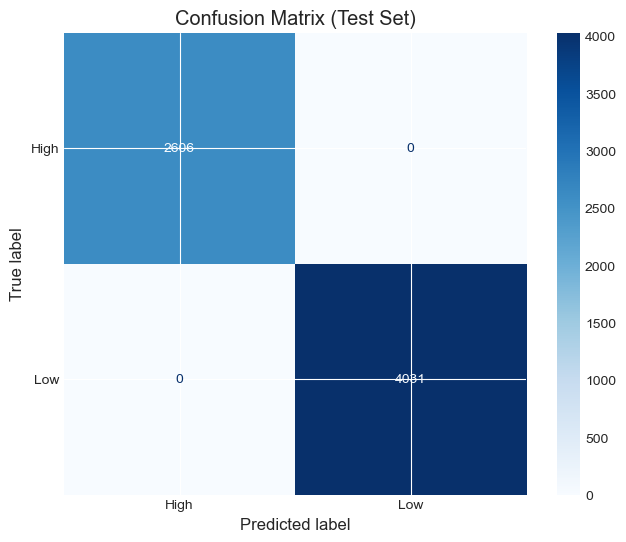

In [141]:
try:
    cm = confusion_matrix(y_test, y_pred_classes) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_) 
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
except Exception as e:
    print(f"Could not plot confusion matrix: {e}")

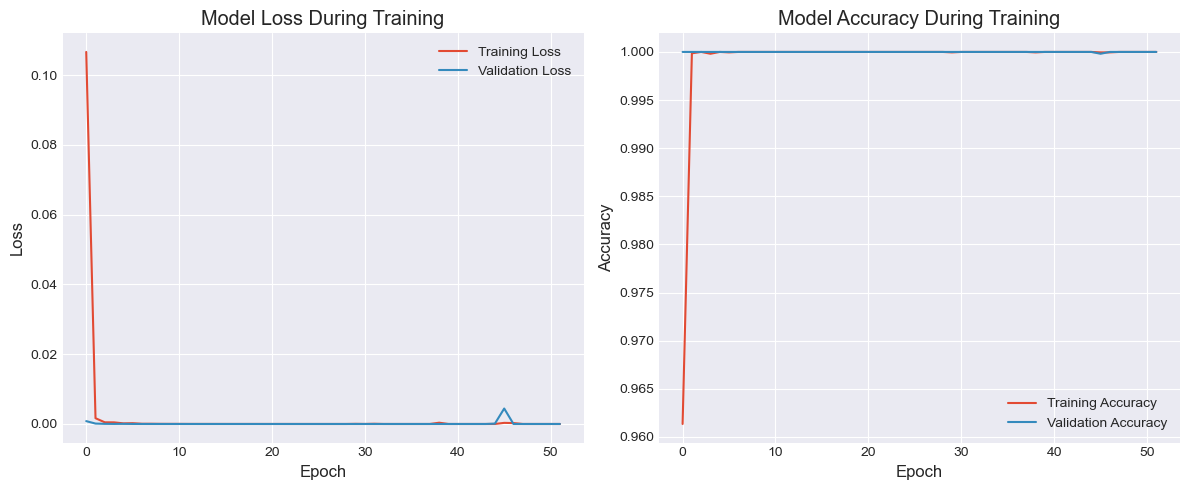

In [142]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()